In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model

In [2]:
# Load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)

### Enter your tag as unique id for saving

In [3]:
import time
timestr = time.strftime("%d%m%Y")
tag = str("sQNN3-"+timestr)

Params in the quantum layer to train: 3
0: ──RX(0.09)─╭●──────────╭X──RX(0.24)─╭●────╭●──────────────────────────────────────╭RX(0.54)
1: ──RX(0.24)─╰X─╭●───────│───RX(0.24)─├●─╭●─╰RX(0.83)─╭●────────────────────────────│────────
2: ──RX(0.73)────╰X─╭●────│───RX(0.05)─╰X─├●─╭●────────╰RX(0.63)─╭●──────────────────│────────
3: ──RX(0.20)───────╰X─╭●─│───RX(0.41)────╰X─├●──────────────────╰RX(0.54)─╭●────────│────────
4: ──RX(0.10)──────────╰X─╰●──RX(0.71)───────╰X────────────────────────────╰RX(0.21)─╰●───────

──╭●──────────────────────────────────────╭RX(0.80)─┤  <Z>
──╰RX(0.70)─╭●────────────────────────────│─────────┤  <Z>
────────────╰RX(0.73)─╭●──────────────────│─────────┤  <Z>
──────────────────────╰RX(0.61)─╭●────────│─────────┤  <Z>
────────────────────────────────╰RX(0.02)─╰●────────┤  <Z>


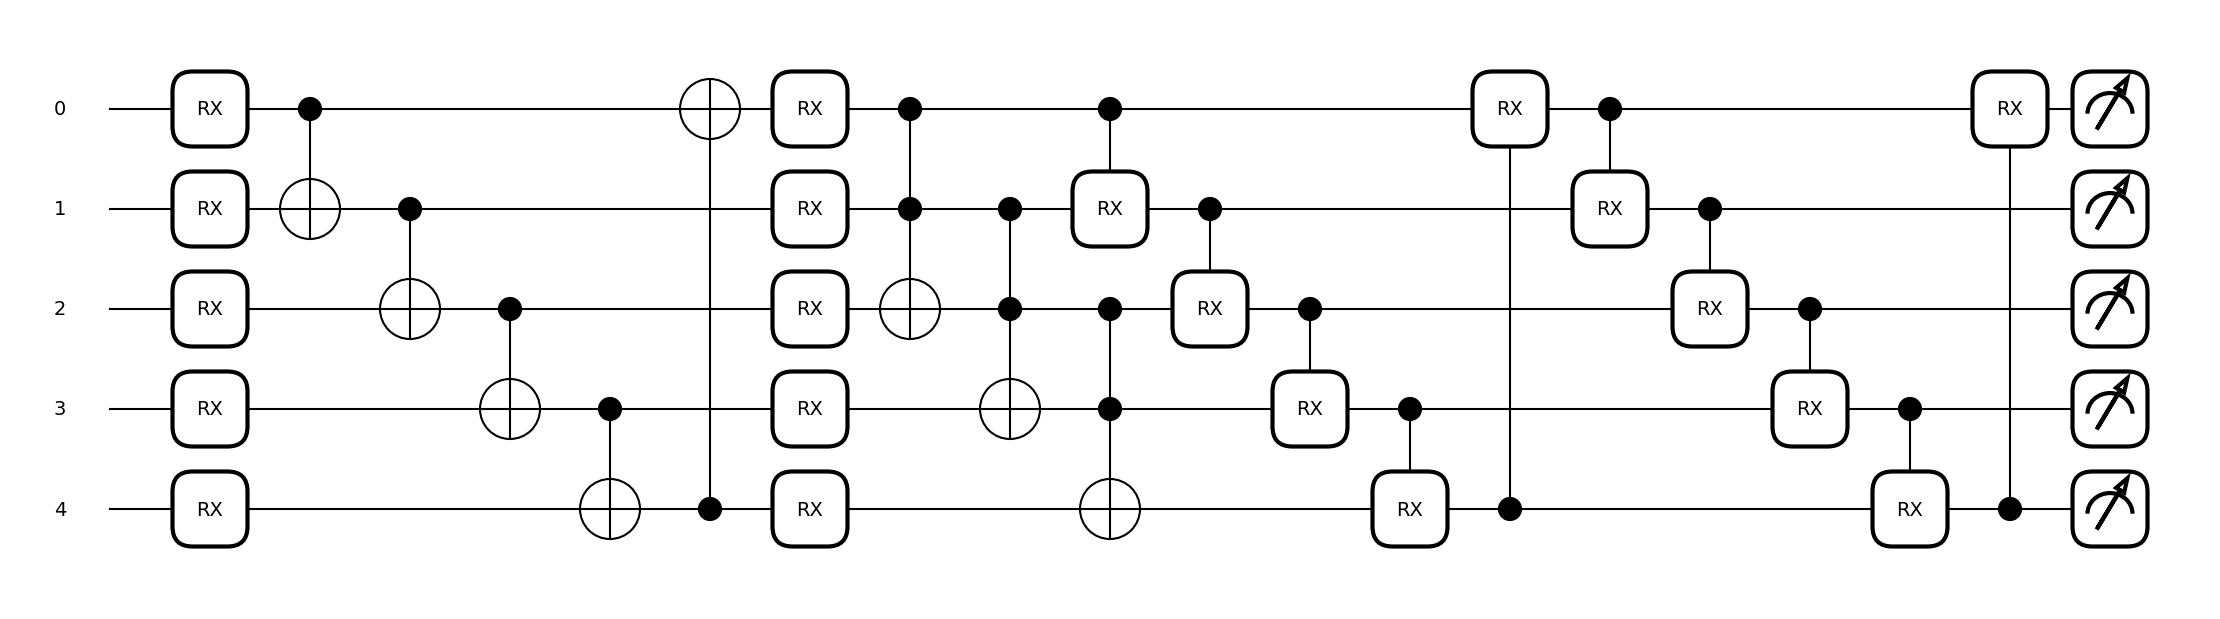

In [4]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
params = 3
weight_shapes = {"weight1": (n_qubits),
                 "weight2": (n_qubits),
                 "weight3": (n_qubits)}
n_qcParams = len(weight_shapes)
print(f"Params in the quantum layer to train: {n_qcParams}")

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weight1, weight2, weight3):
    # qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
    qml.broadcast(qml.RX, wires=range(n_qubits), parameters=inputs, pattern="single")
    qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="ring")
    qml.broadcast(qml.RX, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.Toffoli(wires=[0,1,2])
    qml.Toffoli(wires=[1,2,3])
    qml.Toffoli(wires=[2,3,4])
    qml.broadcast(qml.CRX, wires=range(n_qubits), parameters= weight2, pattern="ring")
    qml.broadcast(qml.CRX, wires=range(n_qubits), parameters= weight3,  pattern="ring")
    # qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(qnode)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits), np.random.rand(n_qubits)))
fig, ax = qml.draw_mpl(qnode)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits), np.random.rand(n_qubits))
plt.show()
fig.savefig("archive/Qnode-"+tag+".png")
fig.savefig("archive/Qnode-"+tag+".pdf")

In [18]:
#Create a simple ANN
import numpy as np
clear_session()
tf.keras.backend.set_floatx('float64')
layer_0 = Input(shape=(x_train.shape[1],))
layer_1 = Dense(5, activation="relu")
layer_2 = Dense(5, activation="linear")
ann = Sequential([layer_0, layer_1, qlayer, layer_2])
print(f"Params in the quantum layer to train: {n_qcParams}")
ann.summary()
plot_model(ann)

Params in the quantum layer to train: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 keras_layer_1 (KerasLayer)  (None, 5)                 0 (unused)
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
#Training
def scheduler(epoch, lr):
    if epoch < 6:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=5, patience=3)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.2, momentum=0.5)

ann.compile(optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

ann_history = ann.fit(x_train, y_train, epochs=20, batch_size=25, validation_split=0.25, callbacks=[LearningRateScheduler, EarlyStopping])

Epoch 1/20
31/31 [==============================] - 118s 4s/step - loss: 8146.8392 - mean_absolute_error: 87.2012 - val_loss: 3180.2552 - val_mean_absolute_error: 55.9582 - lr: 0.2000
Epoch 2/20
31/31 [==============================] - 119s 4s/step - loss: 1023.2138 - mean_absolute_error: 28.6919 - val_loss: 106.9014 - val_mean_absolute_error: 8.7773 - lr: 0.2000
Epoch 3/20
31/31 [==============================] - 121s 4s/step - loss: 80.2608 - mean_absolute_error: 7.0666 - val_loss: 1061.3872 - val_mean_absolute_error: 31.8249 - lr: 0.2000
Epoch 4/20
31/31 [==============================] - 121s 4s/step - loss: 102.8961 - mean_absolute_error: 7.5729 - val_loss: 48.7762 - val_mean_absolute_error: 5.7805 - lr: 0.2000
Epoch 5/20
31/31 [==============================] - 122s 4s/step - loss: 145.3435 - mean_absolute_error: 9.0934 - val_loss: 173.6594 - val_mean_absolute_error: 11.5021 - lr: 0.2000
Epoch 6/20
31/31 [==============================] - 127s 4s/step - loss: 87.8953 - mean_absol

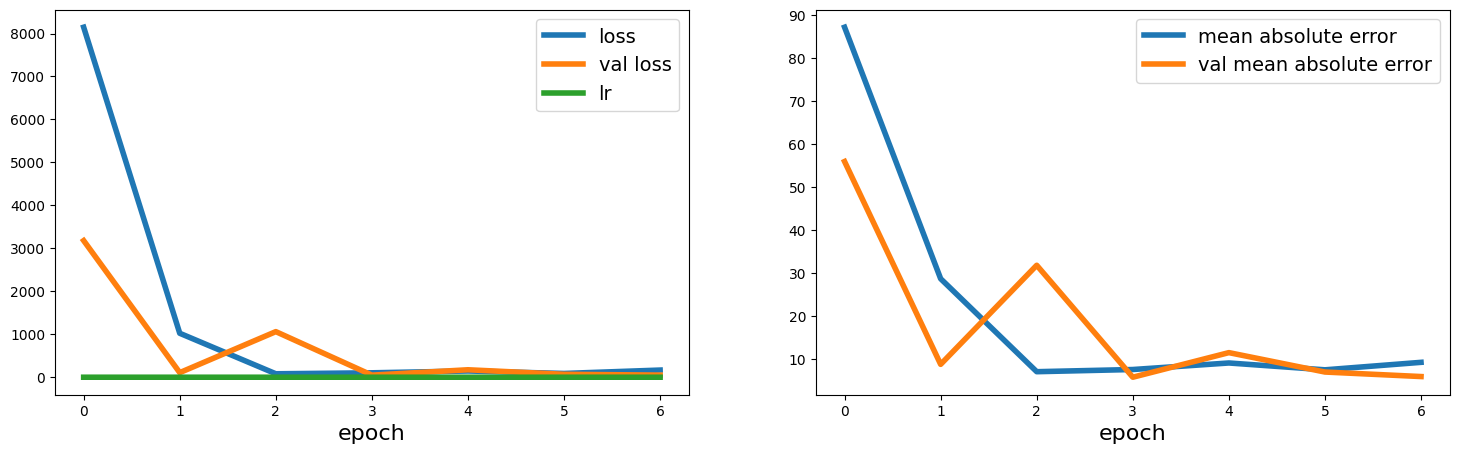

In [20]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(ann_history)

In [ ]:
fig = plt.figure()
plt.plot(ann_history.history['loss'], lw=4, label='loss')
plt.plot(ann_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(ann_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/history-"+tag+".png")

In [21]:
evaluation = ann.evaluate(x_test[:-1], y_test[:-1])
ann.summary()

16/16 [==============================] - 31s 2s/step - loss: 43.1001 - mean_absolute_error: 5.3991
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 keras_layer_1 (KerasLayer)  (None, 5)                 25        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


In [22]:
ann.save("archive/model-"+tag+".h5")
config = ann.get_config()
np.save("archive/config-"+tag+".npy", config)